In [ ]:
# import the required libraries
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
import shutil
import tempfile
from keras import backend as K
import tensorflow as tf
import os
import cv2 
from keras.preprocessing.image import load_img, img_to_array

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Prepare the dataset 
dataset_path = '/content/drive/MyDrive/dataset'

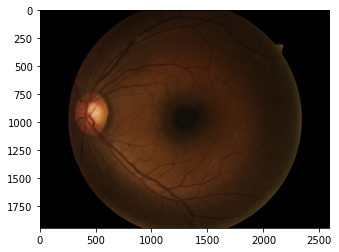

In [ ]:
image_full_path = '/content/drive/MyDrive/dataset/84_left.jpeg'
image = load_img(image_full_path)
image = img_to_array(image)
image = image/255
plt.imshow(image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


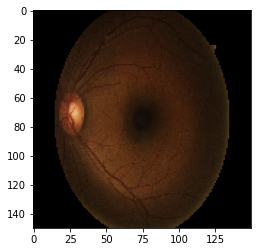

In [ ]:
# Resize the image -  cv2 library
Resize_image = cv2.resize(image, (150,150), interpolation= cv2.INTER_CUBIC)
plt.imshow(Resize_image)

In [ ]:
trainlabels_path = '/content/drive/MyDrive/dataset/trainLabels.csv'

In [ ]:
# load the train labels file
labels_df = pd.read_csv(trainlabels_path, sep = ',')

In [ ]:
labels_df.head()

,image,level
0,84_left,0
1,84_right,0
2,95_left,0
3,95_right,0
4,99_left,3


In [ ]:
labels_df.shape

(1427, 2)

In [ ]:
# the below code shows it is an imbalanced dataset
labels_df['level'].value_counts()

0    1016
2     230
1     113
4      36
3      32
Name: level, dtype: int64

In [ ]:
# groupby the image based on the level(to be used to split the dataset)
train_df = labels_df.groupby("level")[["image", "level"]].sample(frac=0.7, random_state=3)

In [ ]:
train_df.shape

(998, 2)

In [ ]:
train_df['level'].value_counts()

0    711
2    161
1     79
4     25
3     22
Name: level, dtype: int64

In [ ]:
test_df = labels_df.drop(list(train_df.index), axis=0)

In [ ]:
test_df['level'][0]

0

In [ ]:
test_df['level'].value_counts()

0    305
2     69
1     34
4     11
3     10
Name: level, dtype: int64

In [ ]:
# the path for the train and test 
test_path = '/content/drive/MyDrive/dataset/Test'
train_path = '/content/drive/MyDrive/dataset/Train'

In [ ]:
# method to split the dataset into training and test sets based no the level
def split_dataset(df,level,loc_whole_data,subset_path):
     for i, row in df.iterrows():
        if row.level == level:
            img_full_path = os.path.join(os.path.sep, loc_whole_data, row.image)
            img_full_path = img_full_path + '.jpeg'
        
            if not os.path.isfile(img_full_path):
                continue
            location_train_level = subset_path + '/' + str(row.level)
            imageFullPath_to   = os.path.join(os.path.sep, location_train_level, row.image)
            imageFullPath_to   = imageFullPath_to + '.jpeg'
        
            shutil.copy(img_full_path, imageFullPath_to)

In [ ]:
# call the method 5 times on the training df for 5 levels 
for i in range(5):
    split_dataset(train_df, i, dataset_path, train_path)

In [ ]:
# call the method 5 times on the test df for 5 levels 
for i in range(5):
    split_dataset(test_df,i,dataset_path, test_path)

In [ ]:
# test the method 
train_df['level'].value_counts()

0    711
2    161
1     79
4     25
3     22
Name: level, dtype: int64

In [ ]:
eye_images = os.listdir('/content/drive/MyDrive/dataset/Train/0')
len(eye_images)

711

In [ ]:
# test the method 
test_df['level'].value_counts()

0    305
2     69
1     34
4     11
3     10
Name: level, dtype: int64

In [ ]:
eye_images = os.listdir('/content/drive/MyDrive/dataset/Test/0')
len(eye_images)

305

In [ ]:
# Augment the dataset 
train_datagen = ImageDataGenerator(
                                    rescale           = 1.0/255.0,
                                    rotation_range    = 40,            
                                    width_shift_range = 0.1,           
                                    height_shift_range= 0.1,           
                                    shear_range       = 0.1,
                                    zoom_range        = 0.1,         
                                    horizontal_flip   = True,         
                                    vertical_flip     = True,
                                    fill_mode         ='nearest')

In [ ]:
test_datagen = ImageDataGenerator(rescale= 1.0 / 255.0)

In [ ]:
# Define the size of the image
img_width, img_height = 150, 150

In [ ]:
# Define the input shape
if K.image_data_format() == 'channels_first':
    input_shape = (1, img_width, img_height)
else:
    input_shape = (img_width, img_height, 1)

In [ ]:
# Define number of epochs and Batch Size
EPOCHS  = 5 
BatchSize = 32

train_generator = train_datagen.flow_from_directory(
                                                    train_path,
                                                    color_mode = "grayscale",
                                                    target_size = (img_width, img_height),
                                                    batch_size  = BatchSize,
                                                    class_mode  ='categorical'
)

Found 997 images belonging to 5 classes.


In [ ]:
validation_generator = test_datagen.flow_from_directory(
                                                    test_path,
                                                    color_mode = "grayscale",
                                                    target_size = (img_width, img_height),
                                                    batch_size  = BatchSize,
                                                    class_mode  = 'categorical')

Found 429 images belonging to 5 classes.


In [ ]:
# Define the distributed training strategy
strategy = tf.distribute.MirroredStrategy()
print ('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Number of devices: 1


In [ ]:
# Define the checkpoint directory to store the checkpoints.
checkpoint_dir = '/content/drive/MyDrive/Colab Notebooks/training_checkpoints'
# Define the name of the checkpoint files.
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

In [ ]:
callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix,
                                       save_weights_only=True)

In [ ]:
# Define a CNN architecture to extract features from the model data
with strategy.scope():
    # CNN Model
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=input_shape))
    model.add(Activation('relu'))
    #model.add(MaxPooling2D(pool_size=(2, 2))) 
    
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

    model.add(Dense(units=5, activation='softmax'))
    
    # Define the loss, optimizer and evaluation metric
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])


In [ ]:
nb_train_samples      = 997
nb_validation_samples = 429

In [ ]:
train_generator.image_shape

(150, 150, 1)

In [ ]:
validation_generator.image_shape

(150, 150, 1)

In [ ]:
nb_train_samples // BatchSize

31

In [ ]:
# Train the model
model.fit_generator(
                                train_generator,
                                steps_per_epoch  = nb_train_samples // BatchSize,
                                epochs           = EPOCHS, 
                                validation_steps = nb_validation_samples // BatchSize,
                                callbacks        = callback)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/5
31/31 [==============================] - 247s 8s/step - loss: 1.3173 - accuracy: 0.6632
Epoch 2/5
31/31 [==============================] - 193s 6s/step - loss: 0.9554 - accuracy: 0.7150
Epoch 3/5
31/31 [==============================] - 190s 6s/step - loss: 0.9580 - accuracy: 0.7130
Epoch 4/5
31/31 [==============================] - 191s 6s/step - loss: 0.9652 - accuracy: 0.7119
Epoch 5/5
31/31 [==============================] - 191s 6s/step - loss: 0.9509 - accuracy: 0.7140


In [ ]:
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
eval_loss, eval_acc = model.evaluate(validation_generator)
print('Eval loss: {}, Eval accuracy: {}'.format(eval_loss, eval_acc))

14/14 [==============================] - 160s 12s/step - loss: 0.9362 - accuracy: 0.7110
Eval loss: 0.9361620545387268, Eval accuracy: 0.7109557390213013


In [ ]:
# save the model using simple_save 
import tempfile

MODEL_DIR = tempfile.gettempdir()
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))

tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

print('\nSaved model:')
!ls -l {export_path}

export_path = /tmp/1

INFO:tensorflow:Assets written to: /tmp/1/assets

Saved model:
total 180
drwxr-xr-x 2 root root   4096 Feb  6 13:46 assets
-rw-r--r-- 1 root root  17269 Feb  6 13:46 keras_metadata.pb
-rw-r--r-- 1 root root 155316 Feb  6 13:46 saved_model.pb
drwxr-xr-x 2 root root   4096 Feb  6 13:46 variables


In [ ]:
!saved_model_cli show --dir {export_path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['conv2d_input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 150, 150, 1)
        name: serving_default_conv2d_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['dense_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 5)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict

Defined Functions:
  Function Name: '__call__'
    Option #1
      Callable with:
        Argument #1
          inputs:

In [ ]:
# Deploy the saved model using TensorFlow Serving
import sys
# Sudo prefix is needed if not on a Google Colab.
if 'google.colab' not in sys.modules:
  SUDO_IF_NEEDED = 'sudo'
else:
  SUDO_IF_NEEDED = ''

In [ ]:
!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | {SUDO_IF_NEEDED} tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | {SUDO_IF_NEEDED} apt-key add -
!{SUDO_IF_NEEDED} apt update

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0  44590      0 --:--:-- --:--:-- --:--:-- 44590
OK
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease [3,012 B]
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 https://developer.download.nvidia.

In [ ]:
# Install TensorFlow Serving
!{SUDO_IF_NEEDED} apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  cuda-command-line-tools-10-0 cuda-command-line-tools-10-1
  cuda-command-line-tools-11-0 cuda-compiler-10-0 cuda-compiler-10-1
  cuda-compiler-11-0 cuda-cuobjdump-10-0 cuda-cuobjdump-10-1
  cuda-cuobjdump-11-0 cuda-cupti-10-0 cuda-cupti-10-1 cuda-cupti-11-0
  cuda-cupti-dev-11-0 cuda-documentation-10-0 cuda-documentation-10-1
  cuda-documentation-11-0 cuda-documentation-11-1 cuda-gdb-10-0 cuda-gdb-10-1
  cuda-gdb-11-0 cuda-gpu-library-advisor-10-0 cuda-gpu-library-advisor-10-1
  cuda-libraries-10-0 cuda-libraries-10-1 cuda-libraries-11-0
  cuda-memcheck-10-0 cuda-memcheck-10-1 cuda-memcheck-11-0 cuda-nsight-10-0
  cuda-nsight-10-1 cuda-nsight-11-0 cuda-nsight-11-1 cuda-nsight-compute-10-0
  cuda-nsight-compute-10-1 cuda-nsight-compute-11-0 cuda-nsight-compute-11-1
  cuda-nsight-systems-10-1 cuda-nsight-systems-

In [ ]:
os.environ["MODEL_DIR"] =  MODEL_DIR
print(MODEL_DIR)

/tmp


In [ ]:
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=DRR_model \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

Starting job # 0 in a separate thread.


In [ ]:
!tail server.log

2022-02-06 13:47:11.345154: W external/org_tensorflow/tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 87310336 exceeds 10% of free system memory.
2022-02-06 13:47:11.346974: W external/org_tensorflow/tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 87310336 exceeds 10% of free system memory.
2022-02-06 13:47:11.351048: W external/org_tensorflow/tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 87310336 exceeds 10% of free system memory.
[warn] getaddrinfo: address family for nodename not supported
[evhttp_server.cc : 245] NET_LOG: Entering the event loop ...
